# Train Simulation

## Overview
A train network operator wants to find the minimum number of parallel tracks in the train network so that mean delay is smaller than 10 minutes.

- The network has ten track segments and five stations. Each segment has a fixed number of parallel tracks that indicate how many trains can be on the segment at the same time.

- The number of parallel tracks can only be set for all segments at once.

- Each train has a departure station and an arrival station. These are randomly chosen from the five stations.

- A train must pass through a sequence of segments in the correct order to reach its destination. The sequence of segments that a train must pass through is determined by the departure and arrival stations of the train. Passing thorugh one segment always takes 15 minutes.

- When a train requests access to a segment, it must wait until a track becomes available. The time spent waiting is recorded in a list called `delays`.

- After a train has passed through a segment, it continues on to the next segment in the sequence until it reaches its destination.

- There are 500 trains. 25 Trains are ready to leave the station every 30 minutes beginning at minute 0 of the simulation time.

## Scenario Analysis

The network operator wants to keep the mean delay below 30 minutes.<br>
Determine the minimum number of parallel tracks that achieve that goal. <br>
Consider 800 operational minutes of the network. <br>
There is no need to account for possible trains who have not arrived
in their destination after the operational minutes.


## Task
Setup the simulation and find the optimal capacity for the resources according to the business goal.<br>
Do so, by utilizing the code which plots the performance against the capacity.<br>
Use comments to provide your answer.<br>
It is not required to comment your code.<br>
However, it may help yourself and us to keep track of what you're doing.

Hand in the filled out notebook by Feb 10th 2023 03:00 PM via mail to feddersen@bwl.uni-kiel.de and cleophas@bwl.uni-kiel.de.

In [23]:
### IMPORTS

import simpy
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(110)

### LOGGING
log = open('travel_log.txt','w')
      

### ENTITY PROCESS
# One train passing which passes through its segment_path, waiting for segments to become available

def train(env,train_id,segment_path,passthrough_time=15,departure=0):

    # Train is initiated and starts at departure destination
    yield env.timeout(departure)
    log.write(f'Train {train_id} starts at {env.now}\n')

    # Iteration over all segments on the segment_path
    for segment in segment_path:
        # Create a request event
        with segment.request() as seg:

            # Waiting for Access to the ressource
            t_req = env.now
            yield seg

            # Measure delay and add it to the delays list           
            t_wait = env.now - t_req
            delays.append(t_wait)
            log.write(f'Train {train_id} is now on the next segment after a delay of {t_wait}\n')

            # Elapse time for passing the segment
            yield env.timeout(passthrough_time)
            
    # Arrive at the final destination
    log.write(f'Train {train_id} arrives at the final destination at {env.now}\n')
    
### STATIC WORLD INFORMATION

passthrough_time = 15
operation_minutes = 800
n_trains = 500

earliest_dep = np.repeat(np.arange(0,571,30),repeats=n_trains / 20)

def create_segments_and_paths(env,num_parallel_tracks):

    """
    Create ten track segments represented by simpy resources.

    Each track segment has a fixed number of parallel tracks which indicates
    how many trains can be on the segment at the same time.
    The number of parallel tracks is the same across all segments.
    All segments form a list called 'segments'.

    A sequence of segments connects each pair of five stations.
    The dictionary 'segment_paths' describes how each pair of stations
    is connected by a sequence of segments.
    The keys are said pairs of stations and the values are the sequences of segments.

    The function returns the list of segments and the dictionary of segment paths.
    This means that the function returns two values as a tuple.

    It can be used to add resources to the environment 'env'.

    Example:
    segments, segment_paths = create_segments_and_paths(env,2)

    Now, segments is a list of ten simpy resources and segment_paths is a dictionary.
    

    """

    segment1 = simpy.Resource(env, num_parallel_tracks)
    segment2 = simpy.Resource(env, num_parallel_tracks)
    segment3 = simpy.Resource(env, num_parallel_tracks)
    segment4 = simpy.Resource(env, num_parallel_tracks)
    segment5 = simpy.Resource(env, num_parallel_tracks)
    segment6 = simpy.Resource(env, num_parallel_tracks)
    segment7  = simpy.Resource(env, num_parallel_tracks)
    segment8 = simpy.Resource(env, num_parallel_tracks)
    segment9 = simpy.Resource(env, num_parallel_tracks)
    segment10 = simpy.Resource(env, num_parallel_tracks)

    segment_paths = {
        (1, 2): [segment1, segment3, segment5],
        (1, 3): [segment1, segment2, segment4, segment6],
        (1, 4): [segment1, segment7, segment8],
        (1, 5): [segment1, segment9, segment10],
        (2, 3): [segment2, segment4, segment6],
        (2, 4): [segment2, segment5, segment7, segment8],
        (2, 5): [segment2, segment5, segment9, segment10],
        (3, 4): [segment3, segment7, segment8],
        (3, 5): [segment3, segment9, segment10],
        (4, 5): [segment4, segment8, segment9, segment10],
    }
    add_to_dict = {}
    for (start, end), segments in segment_paths.items():
        add_to_dict[(end, start)] = segments[::-1]

    segment_paths.update(add_to_dict)

    segments = [segment1, segment2, segment3, segment4, segment5, segment6, segment7, segment8, segment9, segment10]
    return segments, segment_paths

### RANDOM ENTITTY INFORMATION
# Random start and end points for each of the trains 
# Departure and arrival nodes must not be the same

start_end_points = np.array([])
for i in range(0,n_trains):
    # Generate random pair of nodes
    tuple = np.random.randint(low=1,high=6,size=(2,1))

    # Ensure that Departure and arrival node are not the same
    while tuple[0] == tuple[1]:
        tuple = np.random.randint(low=1,high=6,size=(2,1))

    start_end_points = np.append(start_end_points,tuple)
start_end_points = np.reshape(start_end_points,(n_trains,2))

### SCENARIO ANALYSIS
parallel_tracks = list(range(1,21))
mean_delays = []

# Simulation for different amount of parallel tracks
for num_parallel_tracks in parallel_tracks:
    env = simpy.Environment()
    segments, segment_paths = create_segments_and_paths(env,num_parallel_tracks)
    delays = []
    for i in range(0,n_trains):
        env.process(train(env,i+1,segment_paths[start_end_points[i][0],start_end_points[i][1]],departure=earliest_dep[i]))
    env.run(operation_minutes)
    mean_delays.append(sum(delays)/len(delays))

# Close log file
log.close()

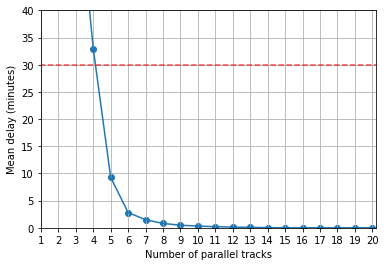

In [20]:
# PLOT RESULTS
plt.plot(parallel_tracks, mean_delays)
plt.scatter(parallel_tracks, mean_delays)
plt.xticks(parallel_tracks)
plt.ylim(0,40)
plt.xlim(1,max(parallel_tracks)+0.2)
plt.hlines(30,0,max(parallel_tracks)+0.2,color='red',ls='--',alpha=0.7)
plt.xlabel('Number of parallel tracks')
plt.ylabel('Mean delay (minutes)')
plt.grid()